In [1]:
import numpy as np
from scipy.optimize import linprog
from scipy import fft
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize']=(14,6)

In [26]:
n = 4096
t = np.linspace(0,1,n)
x = np.cos(2* 97 * np.pi * t) + np.cos(2* 777 * np.pi * t)
xt = np.fft.fftshift(np.fft.fft(x));
PSD = np.real(xt*np.conj(xt))/n

In [27]:
p = 128
perm  = np.floor(np.random.rand(p)*n).astype(int) # randoms from [0, ..., 4096]
y = x[perm]

In [28]:
Psi = fft.dct(np.identity(n))
Theta = Psi[perm, :]

In [29]:
freq = np.arange(n)
L = int(np.floor(n/2))

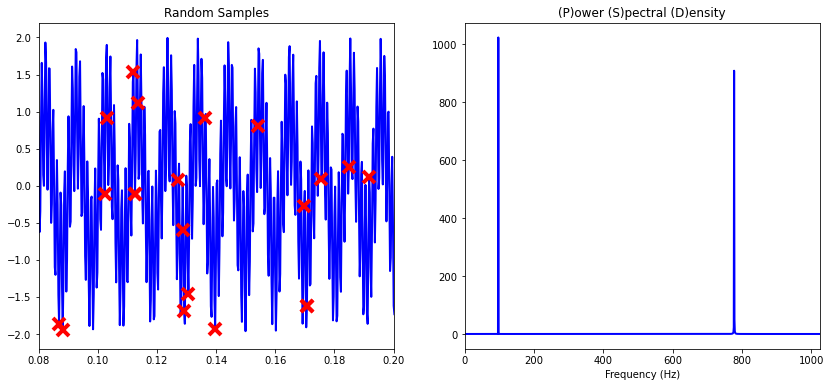

In [30]:
fig, ax = plt.subplots(1,2);


ax[1].plot(freq[:L], PSD[L:], color='b', linewidth=2);
ax[1].set_xlim(0,1024);
ax[1].set_xlabel('Frequency (Hz)');
ax[1].set_title("(P)ower (S)pectral (D)ensity");


ax[0].plot(t, x, color='b', linewidth=2);
ax[0].plot(perm/n, y, color='red', linewidth=0, marker='x', ms=12, mew=4);
ax[0].set_xlim(0.08, 0.20);
ax[0].set_title("Random Samples");

# CoSaMP

In [8]:
# source: https://github.com/avirmaux/CoSaMP

def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [31]:
s_cosamp = cosamp(Theta, y, 10, max_iter = 25)

C:\Users\akira\AppData\Local\Temp/ipykernel_25788/2427991696.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b[omega], _, _, _ = np.linalg.lstsq(phiT, u)


In [32]:
xrecon_cosamp = fft.idct(s_cosamp)

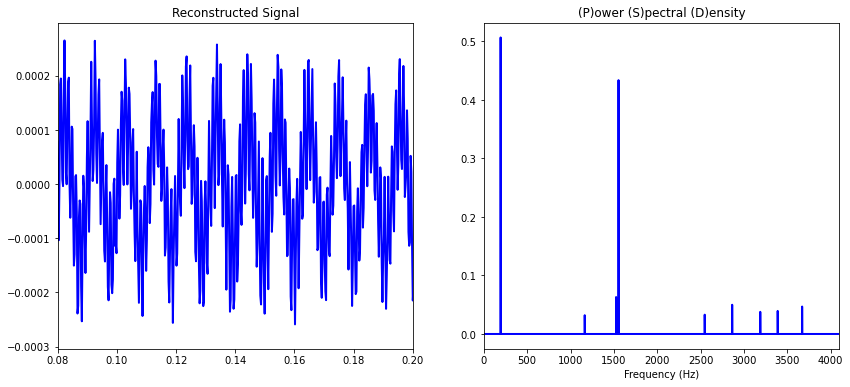

In [33]:
fig, ax = plt.subplots(1,2);

ax[1].plot(s_cosamp, color='b', linewidth=2);
ax[1].set_xlim(0,4096);
ax[1].set_xlabel('Frequency (Hz)');
ax[1].set_title("(P)ower (S)pectral (D)ensity");


ax[0].plot(t, xrecon_cosamp, color='b', linewidth=2);
ax[0].set_xlim(0.08, 0.20);
ax[0].set_title("Reconstructed Signal");

# Linear Program Solution

In [34]:
def solve(A, b):
    _, n = A.shape
    c = np.ones([n, 1])
    return  linprog(c, A_eq=A, b_eq=b).x

In [35]:
s_linprog = solve(Theta, y);

C:\Users\akira\AppData\Local\Temp/ipykernel_25788/1887902098.py:4: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  return  linprog(c, A_eq=A, b_eq=b).x


In [36]:
xrecon_linprog = fft.idct(s_linprog)

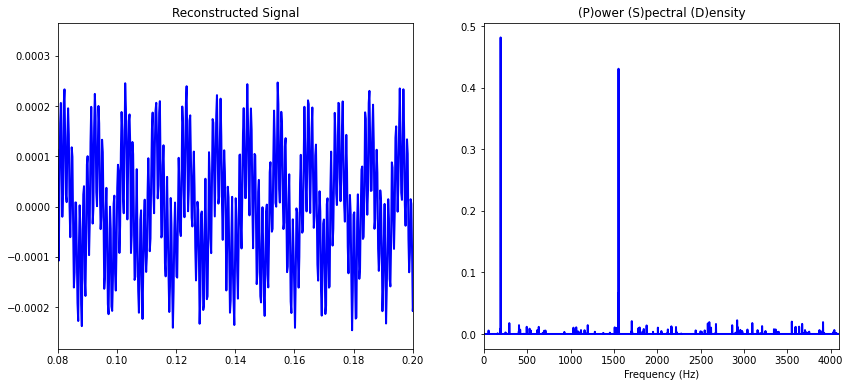

In [37]:
fig, ax = plt.subplots(1,2);

ax[1].plot(s_linprog, color='b', linewidth=2);
ax[1].set_xlim(0,4096);
ax[1].set_xlabel('Frequency (Hz)');
ax[1].set_title("(P)ower (S)pectral (D)ensity");


ax[0].plot(t, xrecon_linprog, color='b', linewidth=2);
ax[0].set_xlim(0.08, 0.20);
ax[0].set_title("Reconstructed Signal");